# Описание проекта

Данные находятся в трёх файлах:
* gold_recovery_train.csv — обучающая выборка;
* gold_recovery_test.csv — тестовая выборка;
* gold_recovery_full.csv — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.

**Инструкция по выполнению проекта**
1. Подготовьте данные
  1. Откройте файлы и изучите их.
  1. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.
  1. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
  1. Проведите предобработку данных.
2. Проанализируйте данные
  1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.
  1.  Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.
  1.  Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.
3. Постройте модель
  1. Напишите функцию для вычисления итоговой sMAPE.
  1. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

## Технологический процесс

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

<img src="viruchka_1576238830.jpg" alt="Drawing" style="width: 640px;"/>


Опишем каждую стадию:
1. Флотация

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

2. Очистка

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

### Описание данных

**Технологический процесс**
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
  * Xanthate **— ксантогенат (промотер, или активатор флотации);
  * Sulphate — сульфат (на данном производстве сульфид натрия);
  * Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

**Параметры этапов**
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

### Наименование признаков

Наименование признаков должно быть такое:

`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:
* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики
Возможные значения для блока `[тип_параметра]`:
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

### Расчёт эффективности

Вам нужно смоделировать процесс восстановления золота из золотосодержащей руды.

Эффективность обогащения рассчитывается по формуле

\begin{align}
{Recovery} = \frac{C\times(F-T)}{F\times(C-T)}\times100\%
\end{align}

где:
* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

**Метрика качества**
Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и предсказания.

Метрика sMAPE вычисляется так:

\begin{align}
{sMAPE} = \frac{1}{N} \sum_{i=1}^{N}\frac{|y_i-\hat{y_i}|}{(|y_i|+|\hat{y_i}|)/2}\times100\%
\end{align}

Нужно спрогнозировать сразу две величины:
* эффективность обогащения чернового концентрата rougher.output.recovery;
* эффективность обогащения финального концентрата final.output.recovery.

Итоговая метрика складывается из двух величин:

\begin{align}
{Итоговое sMAPE} = 25\% \times sMAPE(rougher) + 75\% \times sMAPE(final)
\end{align}

# 1. Подготовка данных

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import defaultdict

PATH_TO_DATA = '/datasets/'
SEED = 21

In [2]:
train = pd.read_csv(os.path.join(PATH_TO_DATA, 'gold_recovery_train.csv'),
                    index_col='date',
                    parse_dates=['date'])
test = pd.read_csv(os.path.join(PATH_TO_DATA, 'gold_recovery_test.csv'),
                    index_col='date',
                    parse_dates=['date'])
full = pd.read_csv(os.path.join(PATH_TO_DATA, 'gold_recovery_full.csv'),
                    index_col='date',
                    parse_dates=['date'])

train.shape, test.shape, full.shape

((16860, 86), (5856, 52), (22716, 86))

Посмотрим какие признаки есть в трейне, но нет в тесте

In [3]:
set(train.columns) - set(test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тесте у нас нет признаков output, так как это целевые признаки.

Так же в тесте нет признаков calculation для этапа rougher, видимо эти данные рассчитываются позднее и не доступны во время процесса.

Проверим расчет recovery в train:
* Вычислим recovery из сырых значений, проверим сколько из них совпало с предоставленными
* Вычислим MAE для рассчитанных значений и исходых

In [5]:
def recovery(C, F, T):
    
    numerator = (C*(F-T))
    denominator =(F*(C-T))
    
    rec = numerator / denominator * 100
    
    #nonzero_denominator = denominator != 0   
    #rec[~nonzero_denominator] = 0
    
    # так как мы не застрахованы от очень больших и очень маленьких значений, то заполним их
    rec[rec<0] = np.nan
    rec[rec>100] = np.nan
    return rec

In [6]:
t,f,c = train['rougher.output.tail_au'], train['rougher.input.feed_au'], train['rougher.output.concentrate_au']
rec = recovery(c, f, t)
right_recovery_sum = np.isclose(train['rougher.output.recovery'], rec).sum()
right_recovery_sum, train.shape[0]-right_recovery_sum

(14287, 2573)

In [7]:
rec.describe()

count    14287.000000
mean        82.394201
std         15.096808
min         -0.000000
25%         79.818372
50%         85.235997
75%         90.131691
max        100.000000
dtype: float64

Совпало 14287 рассчетных с иходными, не совпало 2573, возможно там пропуски.

Для расчета MAE, заполним пропуски нулями =)

In [8]:
mean_absolute_error(train['rougher.output.recovery'].interpolate(method='time'),
                    rec.interpolate(method='time'))

9.35113328539498e-15

In [9]:
rec.isna().sum()

2573

Как мы видим средняя абсолютная ошибка достаточно мала, считаем считаем что recovery посчитан верно

Посмотрим на пропуски в данных в трейне и тесте:

In [10]:
def show_na(df):
    na_info = (df.isna() | df.isnull()).sum()
    res = (pd.concat([na_info / df.shape[0], na_info], axis=1,  keys=['percent', 'abs'])
           .sort_values('percent', ascending=False))
    return res


show_na(train).head(10)

,percent,abs
rougher.output.recovery,0.152610,2573
rougher.output.tail_ag,0.133452,2250
rougher.output.tail_sol,0.133393,2249
rougher.output.tail_au,0.133393,2249
secondary_cleaner.output.tail_sol,0.117794,1986
rougher.input.floatbank11_xanthate,0.112930,1904
final.output.recovery,0.090214,1521
primary_cleaner.input.sulfate,0.077521,1307
primary_cleaner.input.depressant,0.074852,1262
rougher.calculation.au_pb_ratio,0.073665,1242


In [11]:
show_na(test).head(10)

,percent,abs
rougher.input.floatbank11_xanthate,0.060280,353
primary_cleaner.input.sulfate,0.051571,302
primary_cleaner.input.depressant,0.048497,284
rougher.input.floatbank10_sulfate,0.043887,257
primary_cleaner.input.xanthate,0.028347,166
rougher.input.floatbank10_xanthate,0.021004,123
rougher.input.feed_sol,0.011441,67
rougher.input.floatbank11_sulfate,0.009392,55
rougher.input.feed_rate,0.006831,40
secondary_cleaner.state.floatbank3_a_air,0.005806,34


Пропуски в тесте не значительны

Пропуски в трейне более значитиельны, большая часть из них в целевых признаках *.output.*, так же в rougher.output.recovery пропусков 2573 что совпадает с количеством несовпавших расчетных значений

Пока не будем обрабатывть пропуски, при машинном обучении на кросс-валидации проверим какой способ заполнения или удаления пропусков покажет себя лучше

## Подготовка данных

Для подготовки данных к машинному обучению
1. Удалим из train признаки которых нет в тесте
1. Разделим данные не целевой признак и все остальные
1. Так же разделим датасет на 2 части rougher и cleaner, так как процессы флотации и очистки не зависимы, то и предсказывать их тоже логично независимо.

Возможно предсказзывать recovery вообще не верный путь, так как он зависит от одного из обучающих параметров, может лучше для каждого процесса предсказыать output.concentrate и output.tail и затем на их основе уже считать recovery.

Проверим это на этапе машинного обучения, пока что просто запишем эти данные в отдельные переменные

In [12]:
X_train = train[test.columns]

rougher_cols = X_train.columns.str.contains('rougher')
X_train_rougher = X_train.loc[:, rougher_cols]
X_test_rougher = test.loc[:, rougher_cols]
y_train_rougher = train[['rougher.output.tail_au', 'rougher.output.concentrate_au']]

final_cols = X_train.columns.str.contains('cleaner')
X_train_cleaner = X_train.loc[:, final_cols]
X_test_cleaner = test.loc[:, final_cols]
y_train_cleaner = train[['final.output.tail_au', 'final.output.concentrate_au']]

# 2. Анализ данных

Построим распределения концентраций металов на выходе каждого процесса и в хвостах

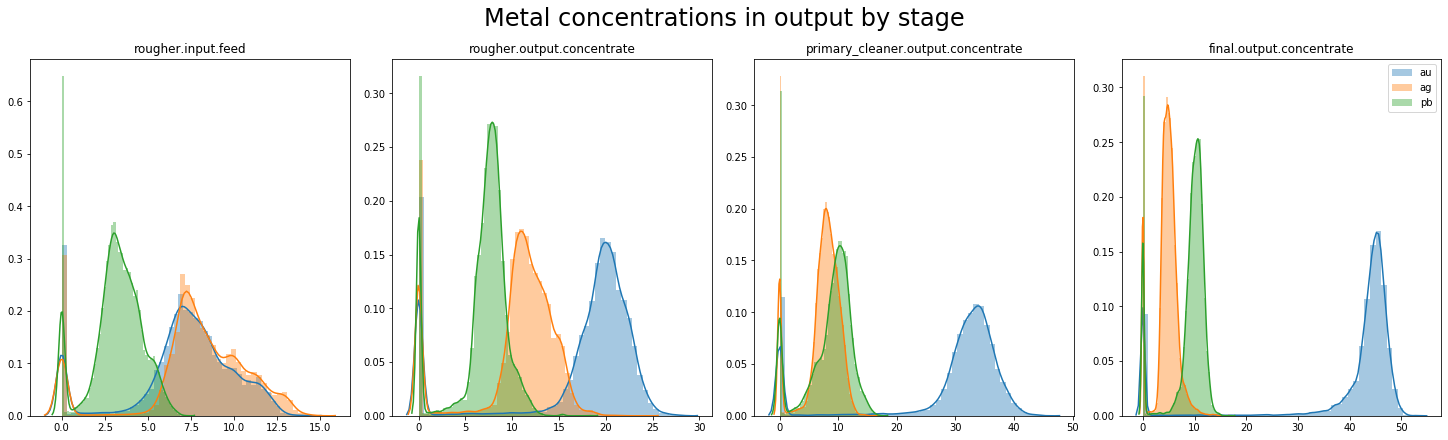

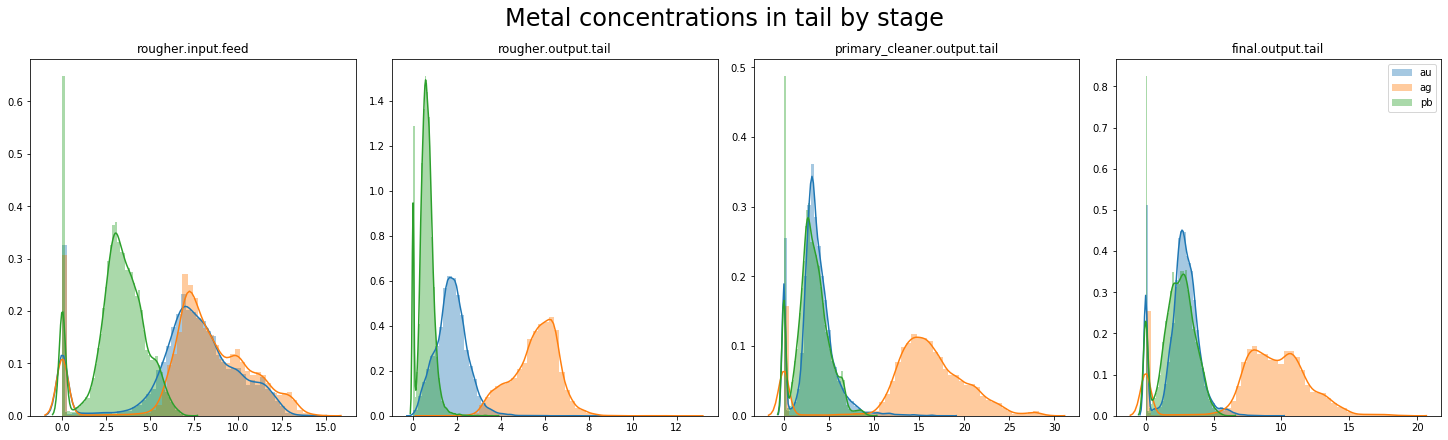

In [13]:
process = ['rougher.input.feed',
           'rougher.output.concentrate',
           'primary_cleaner.output.concentrate',
           'final.output.concentrate']

process_tail = ['rougher.input.feed',
                'rougher.output.tail',
                'primary_cleaner.output.tail',
                'final.output.tail']

metals = ['au', 'ag', 'pb']

fig, axs = plt.subplots(1, len(process), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Metal concentrations in output by stage', fontsize=24)

for stage, ax in zip(process, axs):
    ax.set_title(stage)
    for metal in metals:        
        cols = train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(train.loc[:, cols].dropna(), label=metal, ax=ax)    
plt.legend()

fig, axs = plt.subplots(1, 4, figsize=(20, 6), constrained_layout=True)
fig.suptitle('Metal concentrations in tail by stage', fontsize=24)

for stage, ax in zip(process_tail, axs):
    ax.set_title(stage)
    for metal in metals:        
        cols = train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(train.loc[:, cols].dropna(), label=metal, ax=ax)   
plt.legend()

plt.show()

Из графиков видно что в процессе очистики концентрация золота возрастает, отметим достаточно большое количетсво нулевых значений

Так же отмети различную кноцентрацию металлов в хвостовых отвалах в после различных этапов

Доролнительно посторим графики для концентрации кадого металла на разны процессах на выходе и в хвосте

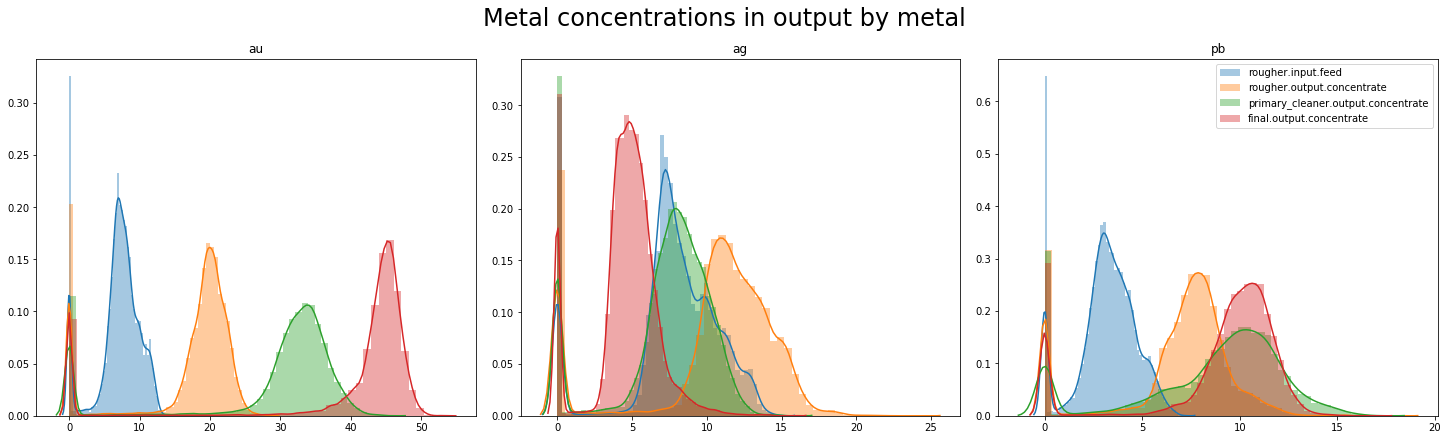

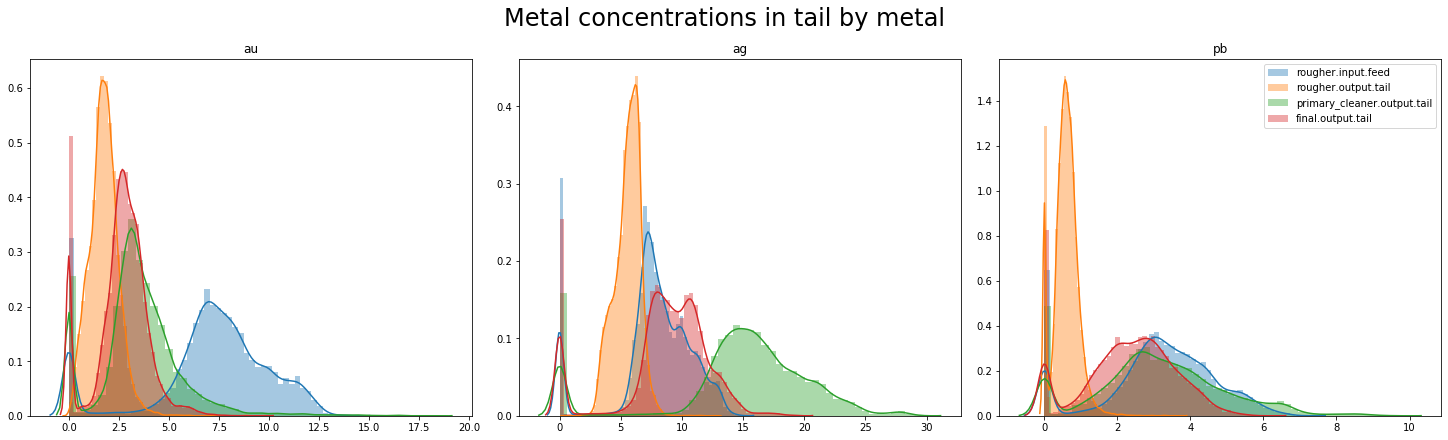

In [14]:
fig, axs = plt.subplots(1, len(metals), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Metal concentrations in output by metal', fontsize=24)

for metal, ax in zip(metals, axs):
    ax.set_title(metal)
    for stage in process:
        cols = train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(train.loc[:, cols].dropna(), label=stage, ax=ax)   
plt.legend()

fig, axs = plt.subplots(1, len(metals), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Metal concentrations in tail by metal', fontsize=24)

for metal, ax in zip(metals, axs):
    ax.set_title(metal)
    for stage in process_tail:
        cols = train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(train.loc[:, cols].dropna(), label=stage, ax=ax)   
plt.legend()

plt.show()

Отметим, что концентрация золота по мере очистки значительно вырастает, так же вырастают концентрации серебра и свинца но не так значительно.

Самая большая концентрация холота в хвостах после флотации, при очиске концентрация золота св хвоствх чуть меньше. Тоже самое характерно для других металлов.

Проверим размер гранул сырья в трейне и в тесте

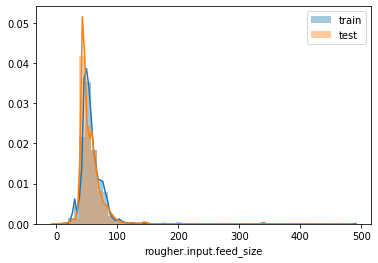

In [15]:
sns.distplot(train['rougher.input.feed_size'].dropna(), label='train')
sns.distplot(test['rougher.input.feed_size'].dropna(), label='test')
plt.legend()

Как мы видим распределения очень похожи

Исследуем суммарню концерацию в разных процессах в трейне и в тесте

PS не очень понимаю зачем это нужно, видимо что бы найти большое количество нулевых значений и что-то с ними сделать

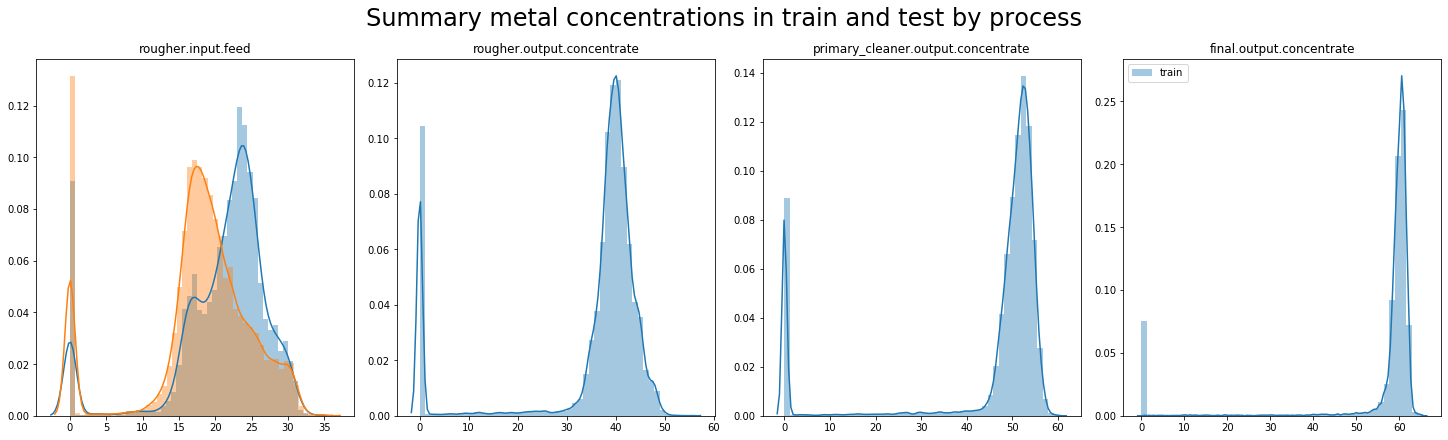

In [16]:
fig, axs = plt.subplots(1, len(process), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Summary metal concentrations in train and test by process', fontsize=24)

for stage, ax in zip(process, axs):
    ax.set_title(stage)
    sum_train = train[stage+ '_ag'] + train[stage+ '_au'] + train[stage+ '_pb']
    try:
        sum_test = test[stage+ '_ag'] + test[stage+ '_au'] + test[stage+ '_pb']
        sns.distplot(sum_test.dropna(), label='test', ax=ax) 
    except KeyError:
        pass
    sns.distplot(sum_train.dropna(), label='train', ax=ax) 

plt.legend()
plt.show()

# 3. Модель

Реализуем расчет метрики sMAPE

1. Учтем multioutput (рассчет метрики для двух и более столбцов)
2. Учтем что формула теряет смысл если в знаменателе 0

In [17]:
def sMAPE(y_true, y_pred, multioutput='uniform_average'):
    
    numerator = np.abs(y_true-y_pred)
    denominator =(np.abs(y_true)+np.abs(y_pred))/2
    
    output_errors = np.divide(numerator, denominator)
    
    nonzero_denominator = denominator != 0   
    output_errors[~nonzero_denominator] = 0
    
    output_scores = np.average(output_errors, axis=0)
    
    if multioutput == 'raw_values':
        return output_scores
    elif multioutput == 'uniform_average':
        pass
    return np.average(output_scores)


neg_smape = make_scorer(sMAPE, greater_is_better=False)

Перейдем к машинному обучению, стратегия следующая:

1. Готовим пайплайн: Заполнение пропусков -> Скалер(для регрессии) -> Модель
1. Готовим параметры для поиска по сетке
1. Заполним пропуски в целевой переменной и удалим нули из нее. только для train
1. Делаем поиск по сетке, выбираем лучшую модель для флотации по метрике sMAPE
1. То же самое для очистки
1. Прогоняем пайплайн с лушими параметрами по всем данным, получаем предсказания для теста выходной и хвостовой концентраций
1. Расчитываем recovery, для каждой стадидии.
1. Подглядываем в full и смотрим конечное значение метрики

In [18]:
pipe = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan)),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=SEED))
])

params = [
    {
        'imp__strategy': ['mean', 'median', 'most_frequent'],
        'model': [RandomForestRegressor(n_estimators=10, random_state=SEED)],
        'model__max_features': np.linspace(0.1, 1, 10)
    }, {
        'imp__strategy': ['mean', 'median', 'most_frequent'],
        'model': [LinearRegression()]
    }, {
        'imp__strategy': ['mean', 'median', 'most_frequent'],
        'model': [Ridge(random_state=SEED)],
        'model__alpha': np.logspace(-3, 1, 10)
    }, {
        'imp__strategy': ['mean', 'median', 'most_frequent'],
        'model': [Lasso(random_state=SEED)],
        'model__alpha': np.logspace(-3, 1, 10)
    }
]

In [19]:
#переделал на заполнение интерполяцией
def fill_target_nan(y):
    y = y.interpolate(method='time')
    return y


def drop_target_zeros(X, y):
    y = y[(y != 0).all(1)]  
    X = X.loc[y.index, :]
    return X, y


print('Shapes before:')
print(X_train_rougher.shape, y_train_rougher.shape,
      X_train_cleaner.shape, y_train_cleaner.shape)

y_train_rougher = fill_target_nan(y_train_rougher)
y_train_cleaner = fill_target_nan(y_train_cleaner)

X_train_rougher, y_train_rougher = drop_target_zeros(X_train_rougher, y_train_rougher)
X_train_cleaner, y_train_cleaner = drop_target_zeros(X_train_cleaner, y_train_cleaner)        
                
print('Shapes after:')
print(X_train_rougher.shape, y_train_rougher.shape,
      X_train_cleaner.shape, y_train_cleaner.shape)       

Shapes before:
(16860, 22) (16860, 2) (16860, 30) (16860, 2)
Shapes after:
(15313, 22) (15313, 2) (15038, 30) (15038, 2)


<font color=green>Класс. Проверка размеров - это огромный плюс прям круто:)</font>

In [20]:
#cv = KFold(n_splits=5, shuffle=False, random_state=SEED)
cv =TimeSeriesSplit(n_splits=3)
# возможно тут надо применить TimeSeriesSplit
# но из услови задачи не понятно, насколько процессы зависимы от времени и их длительность

grid_rougher = GridSearchCV(pipe, param_grid=params, cv=cv, scoring=neg_smape, n_jobs=-1)

Тут напрашивается валидация по 3 фолдам так как судя по индекcам, для теста выдернули пару месяцев из каждого года. И трейн разбился на 3 части

См иллюстрацию ниже

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


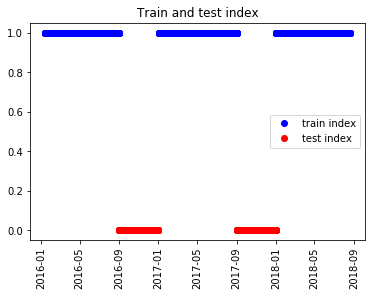

In [21]:
temp = np.ones(train.shape[0])
plt.plot(pd.Series(data=temp, index=train.index), 'bo', c='blue', label='train index')

temp = np.zeros(test.shape[0])
plt.plot(pd.Series(data=temp, index=test.index), 'bo', c='red', label='test index')

plt.title('Train and test index')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [22]:
%%time
grid_rougher.fit(X_train_rougher, y_train_rougher)

CPU times: user 1min 50s, sys: 24.1 s, total: 2min 14s
Wall time: 2min 15s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        RandomForestRegressor(boo

In [23]:
grid_rougher.best_params_, grid_rougher.best_score_

({'imp__strategy': 'mean',
  'model': Lasso(alpha=0.021544346900318832, copy_X=True, fit_intercept=True,
        max_iter=1000, normalize=False, positive=False, precompute=False,
        random_state=21, selection='cyclic', tol=0.0001, warm_start=False),
  'model__alpha': 0.021544346900318832},
 -0.2837030162412595)

In [24]:
grid_cleaner = GridSearchCV(pipe, param_grid=params, cv=cv, scoring=neg_smape, n_jobs=-1)

In [25]:
%%time
grid_cleaner.fit(X_train_cleaner, y_train_cleaner)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.780756186679355, tolerance: 9.402729774037981
  positive)


CPU times: user 3min 17s, sys: 31.2 s, total: 3min 48s
Wall time: 3min 50s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        RandomForestRegressor(boo

In [26]:
grid_cleaner.best_params_, grid_cleaner.best_score_

({'imp__strategy': 'mean',
  'model': Lasso(alpha=1.2915496650148828, copy_X=True, fit_intercept=True, max_iter=1000,
        normalize=False, positive=False, precompute=False, random_state=21,
        selection='cyclic', tol=0.0001, warm_start=False),
  'model__alpha': 1.2915496650148828},
 -0.17534833465197444)

In [27]:
input_au = test['rougher.input.feed_au'].fillna(0)

pipe_rougher = grid_rougher.best_estimator_

if type(pipe_rougher.steps[2][1]) is type(RandomForestRegressor()):    
    pipe_rougher.steps[2][1].n_estimators = 100 #с увеличением числа деревьев качество должно улучшаться
    
pipe_rougher.fit(X_train_rougher, y_train_rougher)

y_pred_rougher_tail, y_pred_rougher_conc = pipe_rougher.predict(X_test_rougher).T
rougher_recovery = recovery(y_pred_rougher_conc, input_au, y_pred_rougher_tail)

smape_rougher = sMAPE(full.loc[X_test_rougher.index, 'rougher.output.recovery'].interpolate(method='time'),
                      rougher_recovery.interpolate(method='time'))
smape_rougher

0.10257891008840601

In [28]:
pipe_cleaner = grid_cleaner.best_estimator_

if type(pipe_cleaner.steps[2][1]) is type(RandomForestRegressor()):    
    pipe_cleaner.steps[2][1].n_estimators = 100 #с увеличением числа деревьев качество должно улучшаться
    
pipe_cleaner.fit(X_train_cleaner, y_train_cleaner)

y_pred_cleaner_tail, y_pred_cleaner_conc = pipe_cleaner.predict(X_test_cleaner).T
cleaner_recovery = recovery(y_pred_cleaner_conc, input_au, y_pred_cleaner_tail)

smape_cleaner = sMAPE(full.loc[X_test_rougher.index, 'final.output.recovery'].fillna(0),
                      cleaner_recovery.fillna(0))
smape_cleaner

0.1348133876901321

In [29]:
final_smape = 0.25*smape_rougher + 0.75*smape_cleaner
final_smape

0.1267547682897006

PS Пришло еще несколько идей:
1. Предсказывать для rougher все остальные output и подавать их как фичи в пайплайн для cleaner
1. Возможно сделать отдельные модели для primari cleaner и second cleaner